<h3>Import packages

In [133]:
import numpy as np
from smt.surrogate_models import KRG, RBF
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
import statistics as st
from sklearn.metrics import r2_score


<h3> Select options

In [134]:
case = 'crushing' # bending / crushing
force = 'max' # max / mean

<h3>Import data

In [135]:
monte_carlo_df = pd.read_csv('monte_carlo_10000.csv').drop(columns=['sample'])
training_df = pd.read_csv('training_data_'+case+'.csv')

<h3>Preprocess data

In [136]:
X = training_df[['outer_wall_thickness', 'inside_wall_side_thickness', 'inside_wall_middle_thickness', 'height', 'width', 'sigma0', 'youngs']].values
Y = training_df[[force+'_force']].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
monte_carlo_array = monte_carlo_df[['outer_wall_thickness', 'inside_wall_side_thickness', 'inside_wall_middle_thickness', 'height', 'width', 'sigma0', 'youngs']].values
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
monte_carlo_array_scaled = scaler.transform(monte_carlo_array)
X_test = scaler.transform(X_test)

<h1>SVR model

<h4>Spesify hyperparameters

In [137]:
C = 778
epsilon = 0.0046
gamma = 0.01

<h4>Run model

In [138]:
SVR_model = SVR(kernel='rbf', C=C, gamma=gamma, epsilon=epsilon, verbose=False)
SVR_model.fit(X_train, Y_train)

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=778, epsilon=0.0046, gamma=0.01)

<h4>Check error

In [139]:
Y_predicted_SVR = SVR_model.predict(X_test)
mape_SVR = mean_absolute_percentage_error(Y_test, Y_predicted_SVR)
r2_SVR = r2_score(Y_test, Y_predicted_SVR)
print("MAPE, for SVR:", format(round(mape_SVR, 4)*100,'.2f'), "%")
print("R2, for SVR:", format(round(r2_SVR, 4),'.2f'))

MAPE, for SVR: 1.27 %
R2, for SVR: 0.91


<h4>Create data for Monte Carlo

In [140]:
predicted_values = SVR_model.predict(monte_carlo_array_scaled)
monte_carlo_df['predicted_'+force+'_force'] = predicted_values
monte_carlo_df.head()
monte_carlo_df.to_csv('monte_carlo_10000_predicted_'+case+'_'+force+'.csv', index=False)

<h1> KRG model

<h4>Spesify hyperparameters

In [141]:
poly = 'linear' # Regression function
corr = 'abs_exp' # Correlation function

<h4>Run model

In [142]:
KRG_model = KRG(
    corr=corr,
    poly=poly, 
    print_global=False
)
KRG_model.set_training_values(X_train, Y_train)
KRG_model.train()

<h4>Check error

In [143]:
"""Y_pred = KRG_model.predict_values(X_test)
mape = mean_absolute_percentage_error(Y_test, Y_pred)
print("MAPE, for KRG:", format(round(float(mape), 4)*100,'.2f'), "%")"""

'Y_pred = KRG_model.predict_values(X_test)\nmape = mean_absolute_percentage_error(Y_test, Y_pred)\nprint("MAPE, for KRG:", format(round(float(mape), 4)*100,\'.2f\'), "%")'

<h4>Create data for Monte Carlo

In [144]:
"""predicted_values = SVR_model.predict(monte_carlo_array_scaled)
monte_carlo_df['predicted_mean_force'] = predicted_values
monte_carlo_df.head()"""

"predicted_values = SVR_model.predict(monte_carlo_array_scaled)\nmonte_carlo_df['predicted_mean_force'] = predicted_values\nmonte_carlo_df.head()"

<h1> Monte Carlo plots

<h3>Convergence of mean

In [145]:
# Check convergence of mean
mean = np.zeros(len(monte_carlo_df))
for i in range(len(monte_carlo_df)):
    mean[i] = np.mean(monte_carlo_df['predicted_mean_force'][:i+1])
plt.figure(dpi=300)
plt.axhline(y=np.mean(monte_carlo_df['predicted_mean_force'][:9999]), color='r', linewidth=2)
#plt.axhline(y=np.mean(monte_carlo_df['predicted_mean_force'][:9999])*1.001, color='r', linewidth=1)
#plt.axhline(y=np.mean(monte_carlo_df['predicted_mean_force'][:9999])*0.999, color='r', linewidth=1)
plt.plot(mean, label='Mean', linewidth=2.5)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.xlabel('Number of samples',fontsize =18)
plt.ylabel('Mean', fontsize =18)
plt.ylim(202, 212)
plt.xlim(-100, 10000)
plt.grid()
plt.show()



KeyError: 'predicted_mean_force'

<h3>Convergence of std

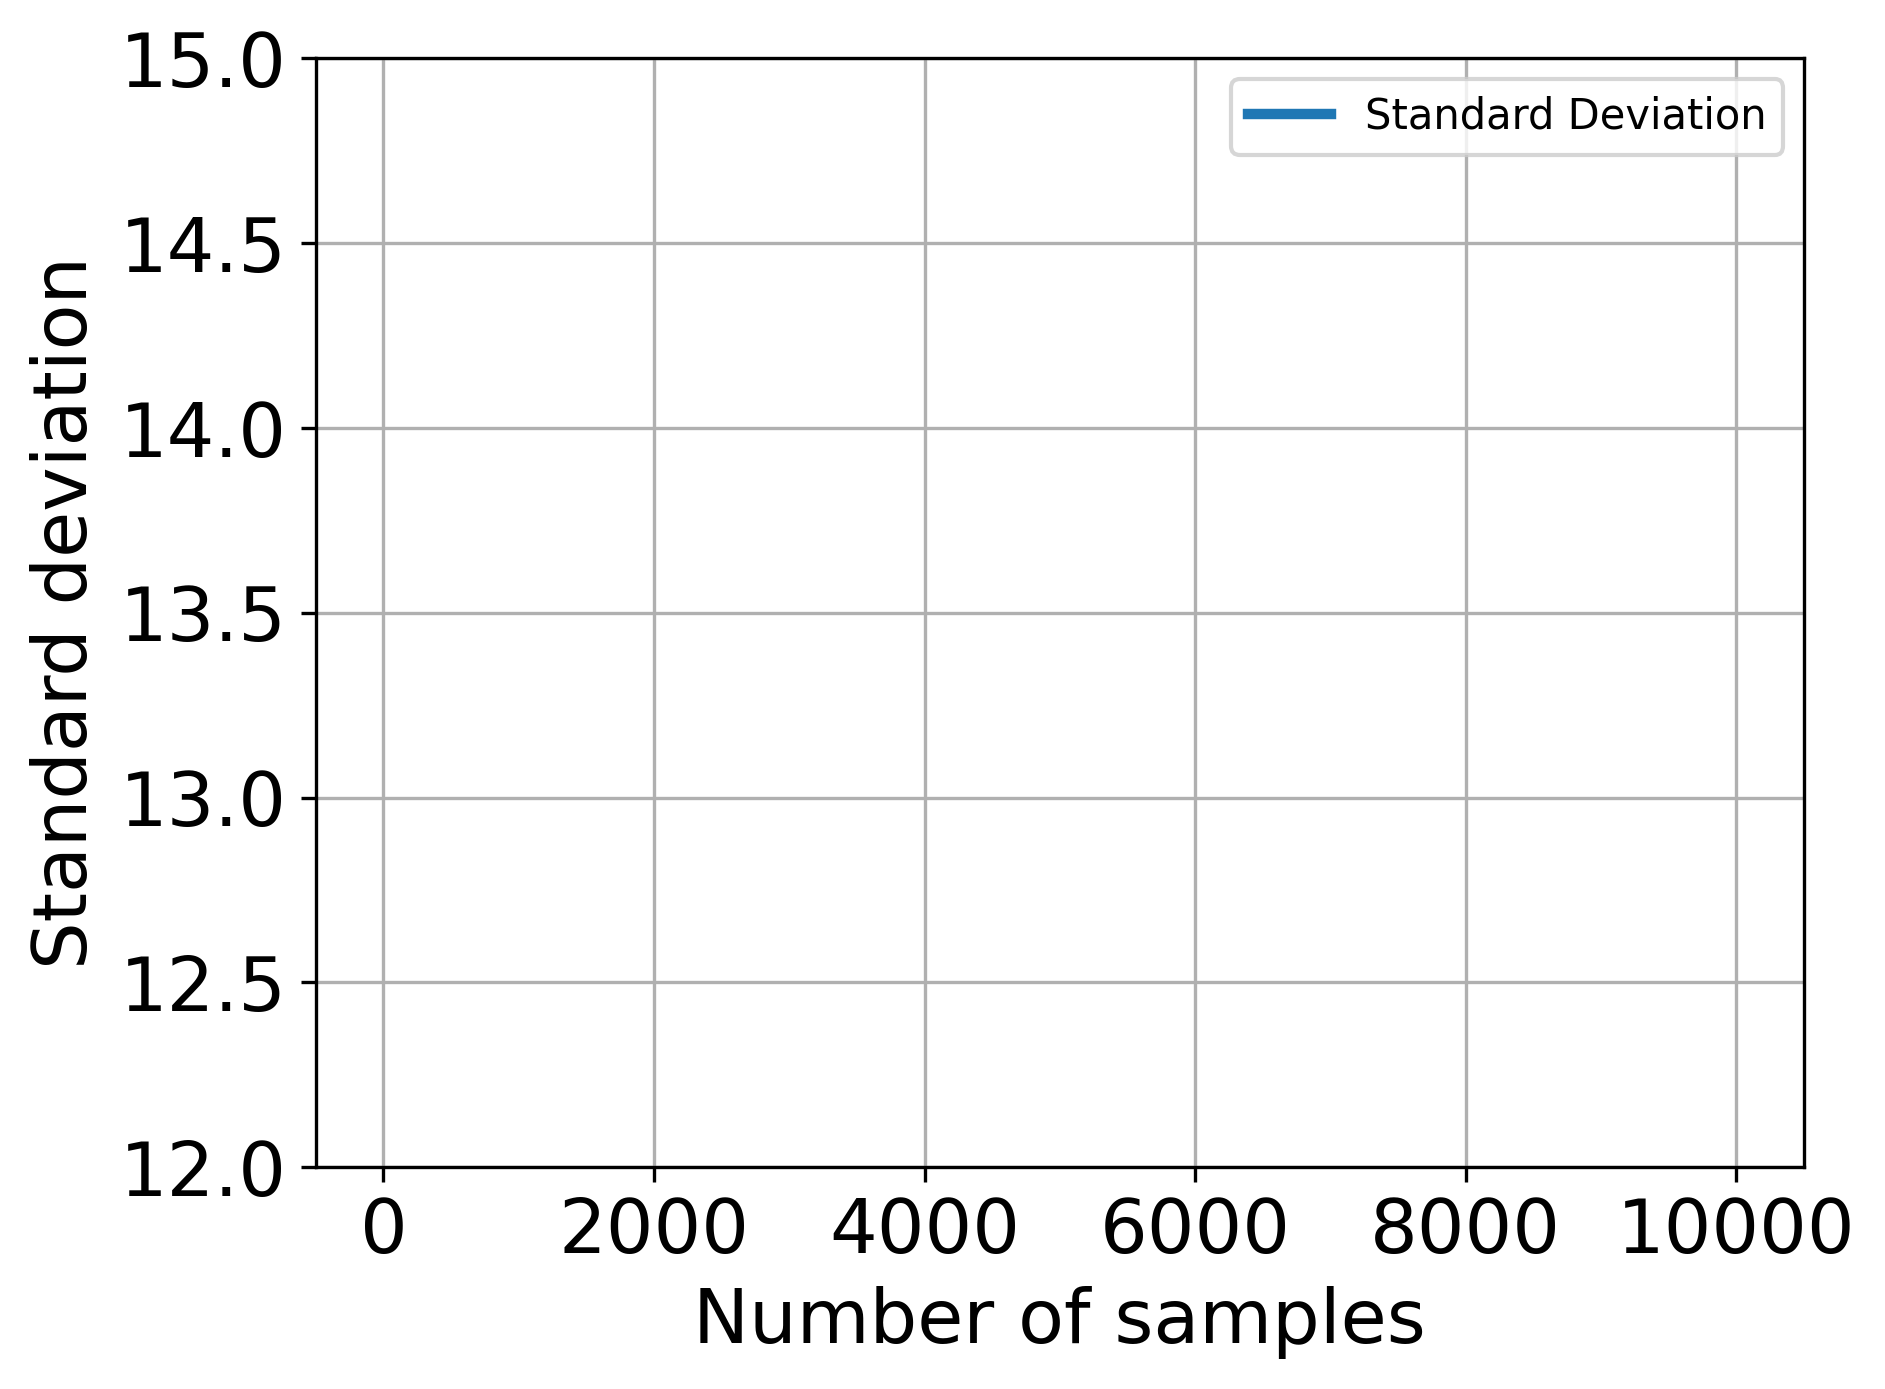

In [ ]:
predicted_std = monte_carlo_df['predicted_mean_force']

# Calculate cumulative standard deviation
std = np.zeros(len(predicted_std))
for i in range(len(predicted_std)):
    std[i] = np.std(predicted_std[:i+1])

plt.figure(dpi=300)
plt.plot(std, label='Standard Deviation', linewidth=2.5)
plt.axhline(y=np.std(monte_carlo_df['predicted_mean_force'][:9999]), color='r', linewidth=2.5)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.ylim(12.0, 15)
plt.xlabel('Number of samples',fontsize=18)
plt.ylabel('Standard deviation', fontsize =18)
plt.grid()
plt.legend()
plt.show()

<h3>Histogram

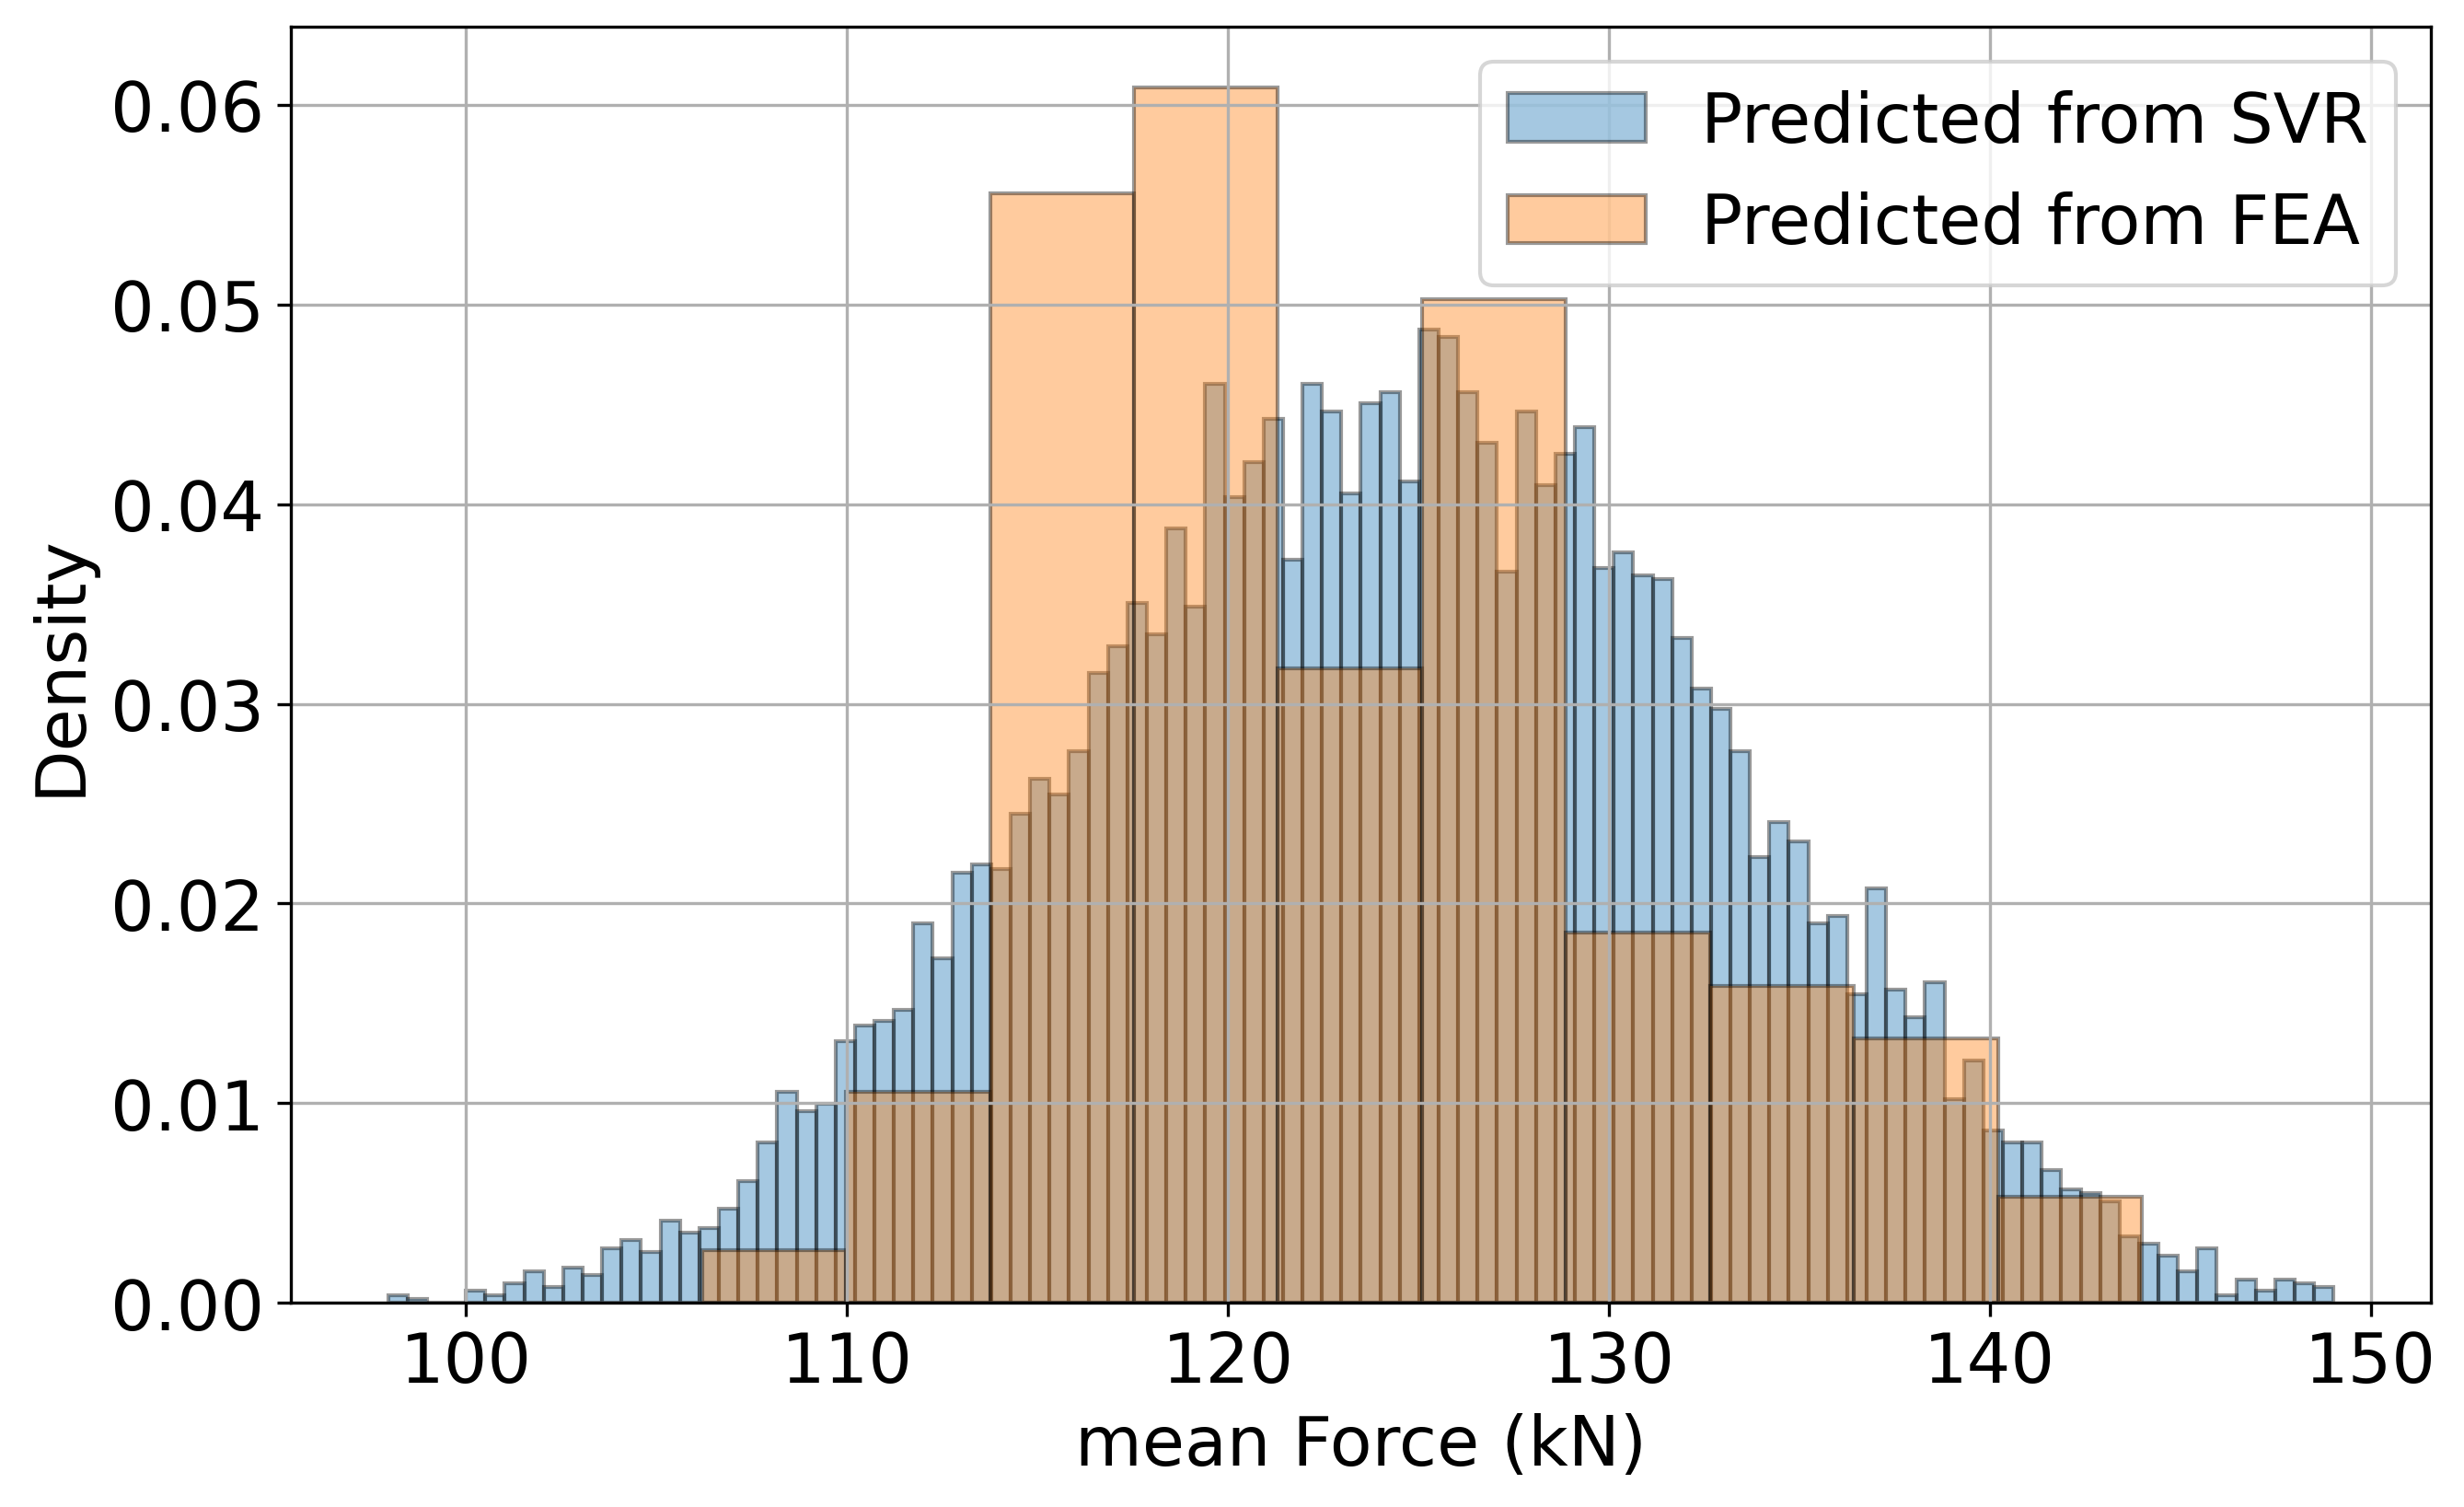

In [ ]:
plt.figure(figsize=(10, 6), dpi=300)
plt.hist(
    x=monte_carlo_df['predicted_mean_force'],
    bins=100,
    label='Predicted from SVR',
    alpha=0.4, 
    edgecolor='black',
    linewidth=1,
    density=True
    )

plt.hist(
    x=training_df[''+force+'_force'], 
    bins=10, 
    label='Predicted from FEA', 
    alpha=0.4, 
    edgecolor='black', 
    linewidth=1,
    density=True
    )

mean = st.mean(monte_carlo_df['predicted_mean_force'])
st_dev = st.stdev(monte_carlo_df['predicted_mean_force'])

#plt.axvline(mean, color ='k', linewidth = 2.5,linestyle = 'dashed', label = 'Mean value')
#plt.axvline(mean+st_dev, color ='y',linestyle = 'dashed',linewidth=2.5, label ='Std.deviation')
#plt.axvline(mean-st_dev, color ='y',linestyle = 'dashed',linewidth= 2.5)
plt.grid()
plt.xlabel(force+' Force (kN)', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.show()


<h3>Changing amount of data

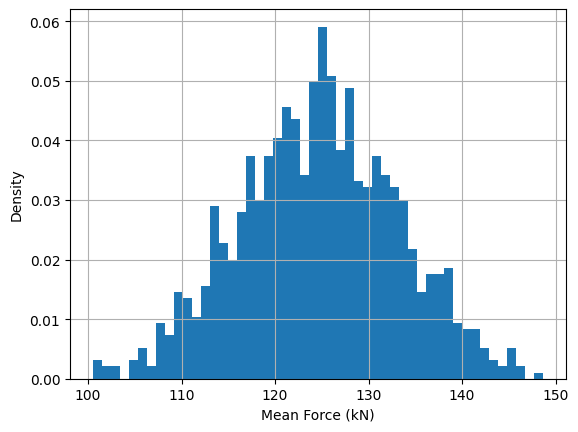

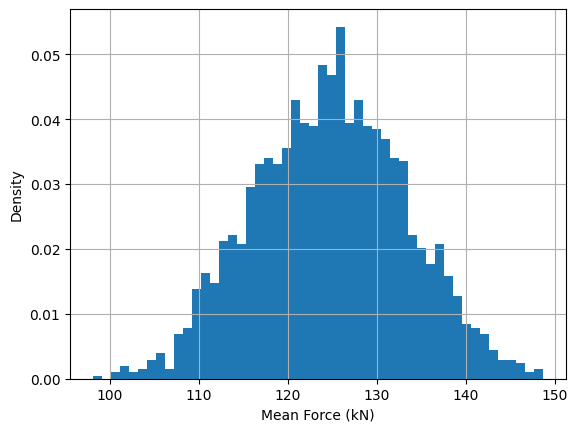

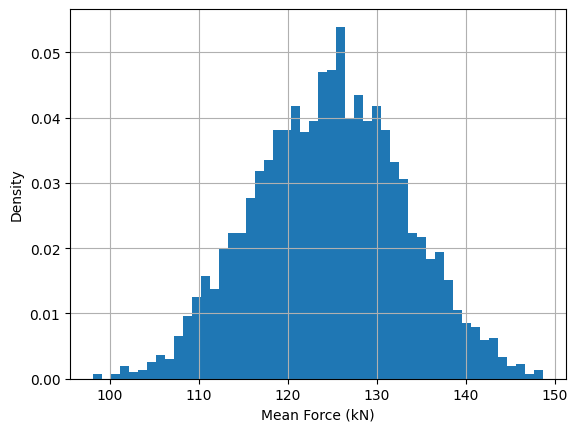

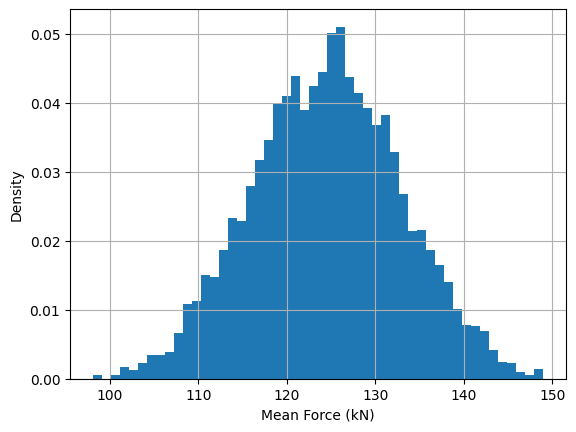

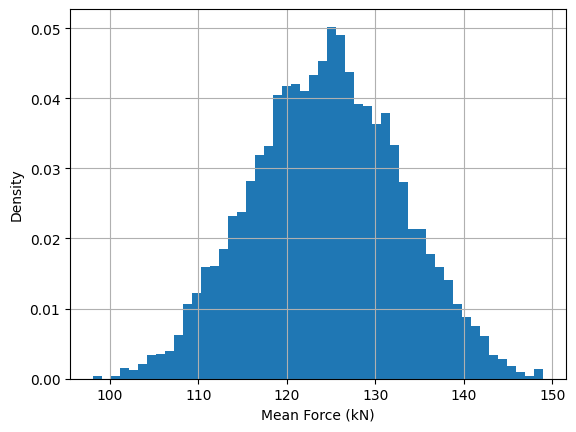

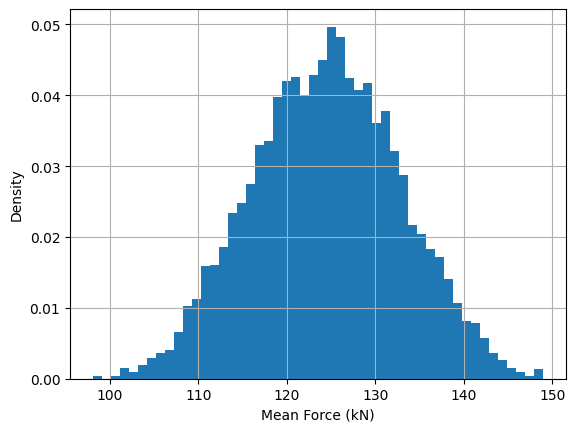

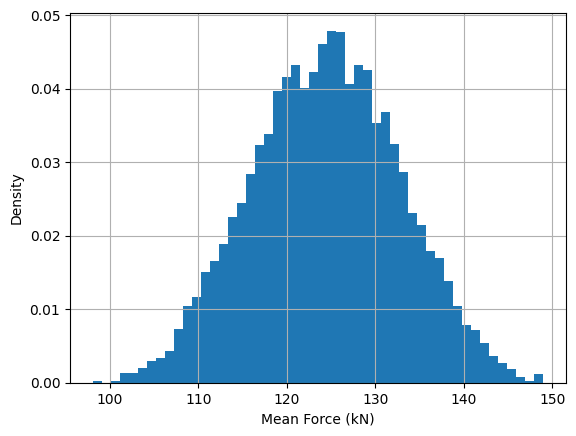

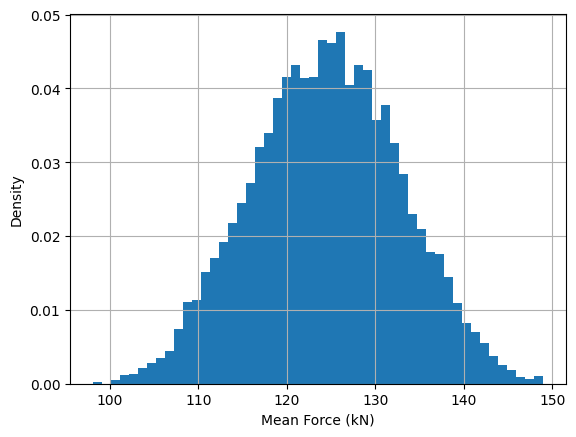

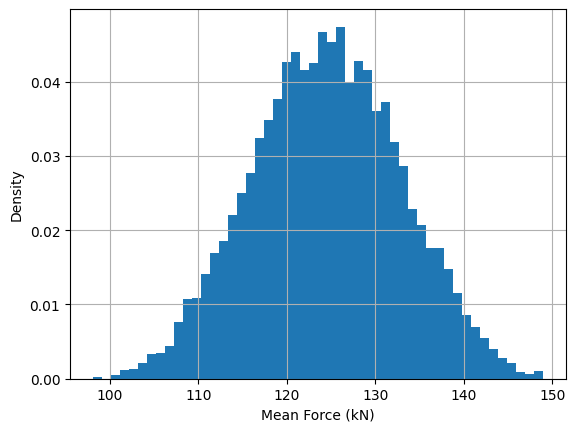

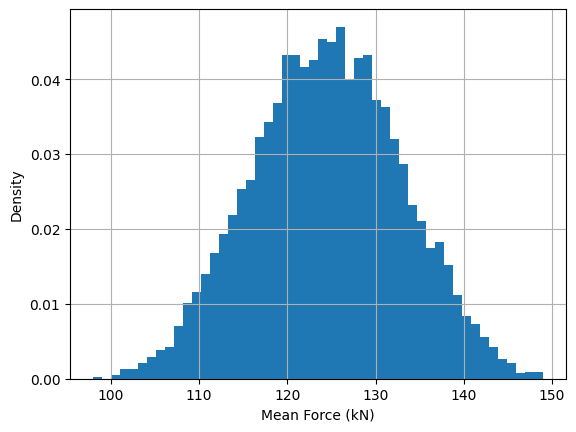

In [ ]:
for i in range(10):
    plt.hist(
        x=monte_carlo_df['predicted_mean_force'][:1000*(i+1)],
        bins=50,
        label='Predicted',
        density=True,
    )
    plt.grid()
    plt.xlabel('Mean Force (kN)')
    plt.ylabel('Density')
    plt.show()

<h3>Changing number of boxes

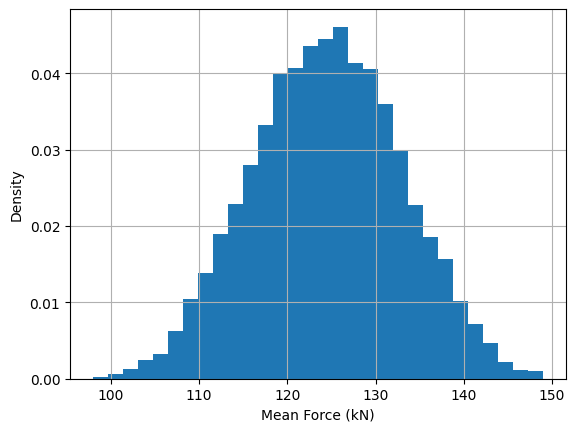

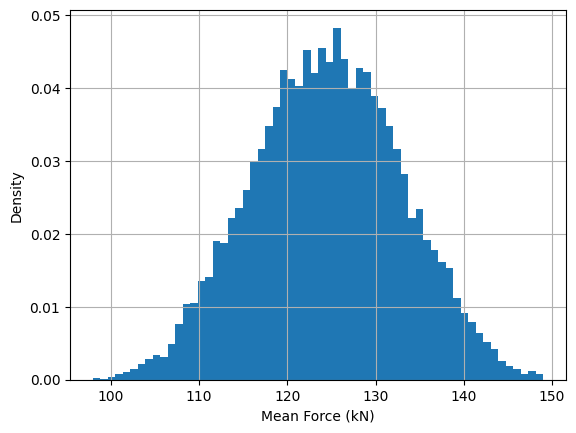

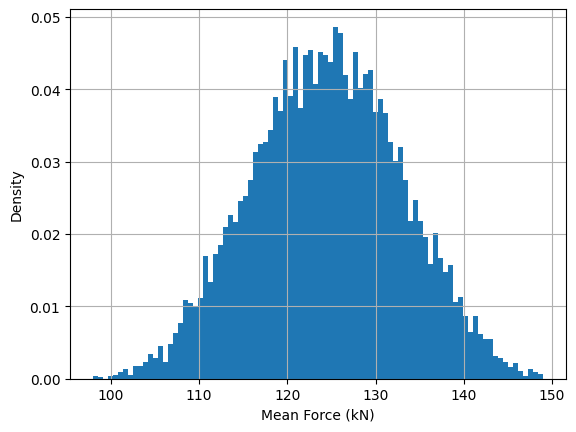

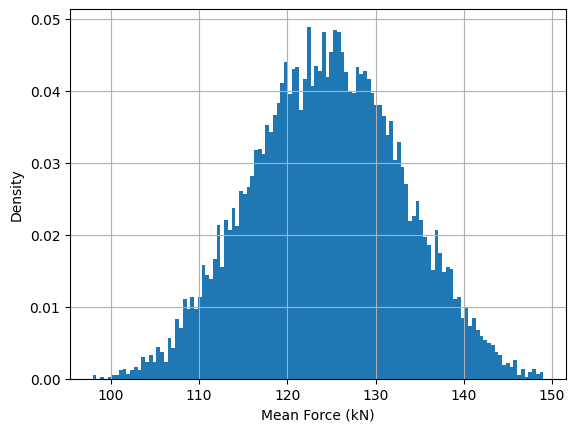

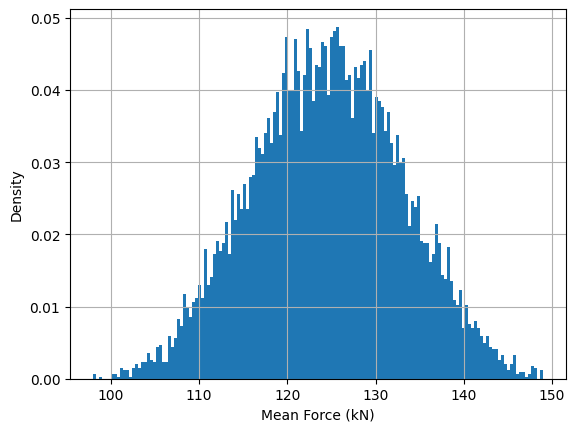

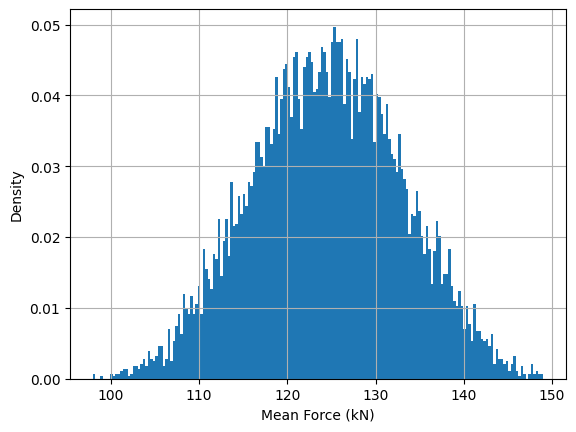

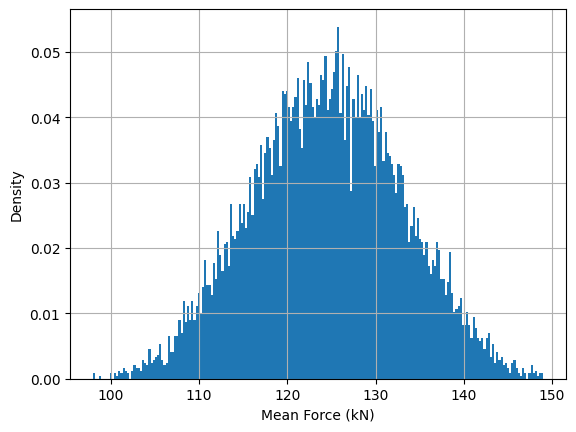

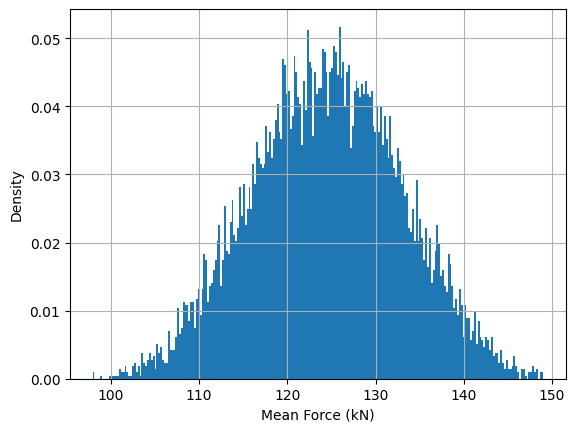

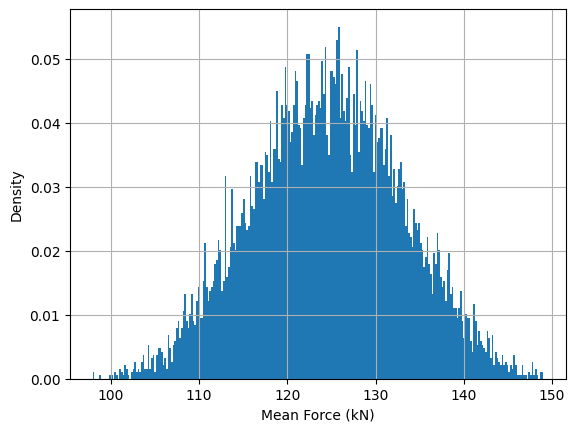

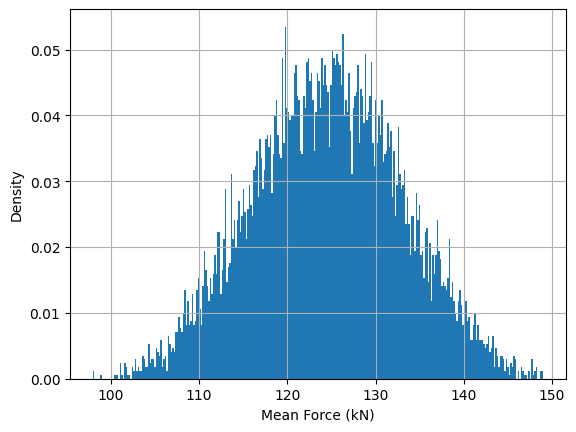

In [ ]:
for i in range(10):
    plt.hist(
        x=monte_carlo_df['predicted_mean_force'],
        bins=30*(i+1),
        label='Predicted',
        density=True
    )
    plt.grid()
    plt.xlabel('Mean Force (kN)')
    plt.ylabel('Density')
    plt.show()